<div style="text-align: center;">
    <img src="fig\ufrj-horizontal-cor-rgb-telas.png" alt="logo ufrj" style="width:25%;">
</div>

<center>

## Métodos Matemáticos Aplicados  EQE-703  J.Luiz   
### Trabalho 1 : Matrizes, Sistemas Lineares, Formas Quadráticas, Autovetores e Autovalores
Maio/2024

</center>


Equipe:
- Francisco Davi Belo Rodrigues
- Christiano Ottoni

Observações:
- Os comentários nos códigos estão padronizados na língua inglesa
- O código pode ser encontrado no repositório: https://github.com/davibelo/EQE703_trabalho_1

In [1]:
import time
import scipy
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


### Questão 1

Considere a matriz simétrica $A$, o vetor $B$, a constante $C$ e a matriz $E$ dados abaixo. Com estes objetos cria-se a Função Objetivo $F(X) = (1/2)X^TAX + B^TX + C$. A partir disto, responda:

(i) Desenvolver programa MATLAB para aplicar o Processo Schmidt à matriz $A$ de modo produzir a base $[P_1, P_2, P_3, P_4, P_5, P_6, P_7, P_8]$ de vetores conjugados por $A$.

Resposta:

In [2]:
# Auxiliar functions that will be used

def display_as_dataframe(array):
    """
    Display a NumPy array as a pandas DataFrame.

    Parameters:
    array (numpy.ndarray): The NumPy array to be displayed.
    """
    # Create a DataFrame from the NumPy array
    df = pd.DataFrame(array)

    # Display the DataFrame
    display(df)


def execution_time_decorator(func):

    def wrapper(*args, **kwargs):
        start_time = time.perf_counter_ns()
        result = func(*args, **kwargs)
        end_time = time.perf_counter_ns()
        execution_time = (end_time - start_time
                          ) / 1000  # converting nanoseconds to microseconds
        print(
            f"Execution Time for {func.__name__}: {execution_time} microseconds"
        )
        return result

    return wrapper


def set_zero_if_below_tolerance(array, tolerance=1e-5):
    """
    Sets elements of a 2D NumPy array to zero if they are below a specified tolerance.

    Parameters:
    array (np.ndarray): Input 2D NumPy array.
    tolerance (float, optional): The tolerance threshold. Default is 1E-10.

    Returns:
    np.ndarray: The modified array with elements below tolerance set to zero.
    """
    # Ensure the input is a NumPy array
    array = np.array(array)

    # Apply the condition using boolean indexing
    array[array < tolerance] = 0

    return array

In [3]:
# Assign values A, B, C, E
A = np.array([[1, 1, 1, 1, 1, 1, 1, 1], [1, 2, 3, 4, 5, 6, 7, 8],
              [1, 3, 6, 10, 15, 21, 28, 36], [1, 4, 10, 20, 35, 56, 84, 120],
              [1, 5, 15, 35, 70, 126, 210, 330],
              [1, 6, 21, 56, 126, 252, 462, 792],
              [1, 7, 28, 84, 210, 462, 924, 1716],
              [1, 8, 36, 120, 330, 792, 1716, 3432]])
print('A = ' )
display_as_dataframe(A)

B = np.array([
    [11111],
    [22222],
    [33333],
    [44444],
    [44444],
    [33333],
    [22222],
    [11111]
])
print('B^T = ')
display_as_dataframe(B.T)

C = 10E5
print('C = ')
print(C)
print('\n')

E = np.array([[4, 0, 4, 0, -3, -4, 3, 1], [-2, -4, 2, 3, -2, 2, 0, -1],
              [1, 3, -3, -4, -3, 0, -2, 3], [0, 0, 0, -1, 1, 4, 1, 0],
              [3, 1, 4, 3, -2, 0, 3, 2], [2, 2, 4, -4, -3, 0, -4, 0]])

print('E = ')
display_as_dataframe(E)
print('\n')

A = 


,0,1,2,3,4,5,6,7
0,1,1,1,1,1,1,1,1
1,1,2,3,4,5,6,7,8
2,1,3,6,10,15,21,28,36
3,1,4,10,20,35,56,84,120
4,1,5,15,35,70,126,210,330
5,1,6,21,56,126,252,462,792
6,1,7,28,84,210,462,924,1716
7,1,8,36,120,330,792,1716,3432


B^T = 


,0,1,2,3,4,5,6,7
0,11111,22222,33333,44444,44444,33333,22222,11111


C = 
1000000.0


E = 


,0,1,2,3,4,5,6,7
0,4,0,4,0,-3,-4,3,1
1,-2,-4,2,3,-2,2,0,-1
2,1,3,-3,-4,-3,0,-2,3
3,0,0,0,-1,1,4,1,0
4,3,1,4,3,-2,0,3,2
5,2,2,4,-4,-3,0,-4,0


In [4]:
@execution_time_decorator
def schmidt_machine(W, M=None):
    """
    Applies the Schmidt process to a matrix W to orthogonalize its column vectors
    or calculate a conjugated base of matrix M.

    Parameters:
    -----------
    W : numpy.ndarray
        The matrix whose column vectors are to be orthogonalized.
    
    M : numpy.ndarray, optional
        The matrix to be conjugated of P

    Returns:
    --------
    numpy.ndarray
        A matrix P where the column vectors are orthogonalized versions 
        of column vectors in W or a conjugated base with matrix M (if M is given).
    """

    # Grant elements as float
    W = W.astype(float)

    # Number of vectors (columns)
    n = W.shape[1]

    # Initialize the orthogonal matrix with zeros
    P = np.zeros_like(W)

    # Make P0 = W0
    P0 = W[:, 0]
    P[:, 0] = P0

    # Set M as identity matrix if not provided
    if M is None:
        M = np.eye(W.shape[0])

    # Loop to calculate P1, P2, ..., Pn-1
    for k in range(1, n):
        # Start with Wk
        Pk = W[:, k]

        # Subtract the projections of Wk onto all previous Pi (i < k)
        for i in range(k):
            Pi = P[:, i]
            Wk = W[:, k]
            alpha = -(Pi.T @ M @ Wk) / (Pi.T @ M @ Pi)
            Pk += alpha * Pi

        # Set the calculated Pi into the ith column of P
        P[:, k] = Pk

    # Normalize columns of P
    for i in range(P.shape[1]):  # Iterate over columns
        vector = P[:, i]
        norm = np.linalg.norm(vector)
        if norm != 0:
            P[:, i] = vector / norm

    return P

In [5]:
P = schmidt_machine(A, A)
print('P = ')
display_as_dataframe(P)

Execution Time for schmidt_machine: 712.5 microseconds
P = 


,0,1,2,3,4,5,6,7
0,0.353553,-0.621937,0.827579,-0.918925,0.700893,-0.350573,0.117650,-0.024271
1,0.353553,-0.520175,0.489399,-0.124726,-0.483267,0.694842,-0.447862,0.151017
2,0.353553,-0.418413,0.227293,0.213274,-0.356596,-0.204861,0.612446,-0.407745
3,0.353553,-0.316650,0.041262,0.238141,0.085604,-0.396740,-0.204580,0.617795
4,0.353553,-0.214888,-0.068693,0.092940,0.275758,0.124859,-0.354996,-0.566312
5,0.353553,-0.113126,-0.102574,-0.079266,0.074012,0.325073,0.447010,0.313650
6,0.353553,-0.011363,-0.060380,-0.135411,-0.231764,-0.264725,-0.203941,-0.097082
7,0.353553,0.090399,0.057889,0.067569,0.074024,0.059848,0.034687,0.012944


(ii) Verificar que estes vetores são conjugados provando o caráter diagonal da matriz $D$ através do produto indicado (no MATLAB): $D = P^TAP$, onde $P = [P_1, P_2, P_3, P_4, P_5, P_6, P_7, P_8]$.

Resposta:

In [6]:
D = (P.T @ A) @ P
D = set_zero_if_below_tolerance(D)
print('D = ')
display_as_dataframe(D)

D = 


,0,1,2,3,4,5,6,7
0,1608.625,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
1,0.000,27.437515,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
2,0.000,0.000000,3.871581,0.000000,0.00000,0.000000,0.000000,0.00000
3,0.000,0.000000,0.000000,1.523812,0.00000,0.000000,0.000000,0.00000
4,0.000,0.000000,0.000000,0.000000,0.48821,0.000000,0.000000,0.00000
5,0.000,0.000000,0.000000,0.000000,0.00000,0.081486,0.000000,0.00000
6,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.006705,0.00000
7,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00022


(iii) Estabelecer o caráter da Forma Quadrática $X^TAX$.
Resposta: 

In [7]:
def classify_diagonal(matrix):
    """
    Classifies the diagonal elements of a 2D NumPy array according to the following rules:
    - PD: all elements are positive
    - PSD: all elements are zero or positive
    - ND: all elements are negative
    - NSD: all elements are zero or negative
    - INDEF: array has positive, negative and zeros
    
    Args:
    matrix (np.ndarray): A 2D NumPy array.

    Returns:
    str: The classification of the diagonal elements.
    """

    if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array")

    diagonal = np.diag(matrix)

    has_positive = np.any(diagonal > 0)
    has_negative = np.any(diagonal < 0)
    has_zero = np.any(diagonal == 0)

    if has_positive and not has_negative and not has_zero:
        return "PD"
    elif has_positive and not has_negative and has_zero:
        return "PSD"
    elif not has_positive and has_negative and not has_zero:
        return "ND"
    elif not has_positive and has_negative and has_zero:
        return "NSD"
    else:
        return "INDEF"

classify_diagonal(D)

'PD'

(iv) Defina a matriz $S$ dada pelas 5 primeiras linhas e 5 primeiras colunas de $A$. Calcule o Determinante de $S$ ($DET(S)$) manualmente pelo método de pivotamento ou implemente um algoritmo computacional no MATLAB (ou outro software) com esta finalidade (não vale usar função pré-pronta para o DET do software em questão). Compare com o valor obtido para $DET(S)$ com função do MATLAB ou de outro software de processamento numérico.

Resposta:

In [8]:
S = A[:5, :5]
display_as_dataframe(S)

,0,1,2,3,4
0,1,1,1,1,1
1,1,2,3,4,5
2,1,3,6,10,15
3,1,4,10,20,35
4,1,5,15,35,70


In [9]:
@execution_time_decorator
def determinant_with_pivoting(matrix, tolerance=1E-6):
    """
    Calculate the determinant of a square matrix using the pivoting method,
    considering a tolerance for treating small numbers as zero.

    Parameters:
    matrix (numpy.ndarray): A square matrix.
    tolerance (float): The tolerance level for treating numbers as zero.

    Returns:
    float or None: The determinant of the matrix. Returns None if the matrix is not square.
    2D numpy array: The triangular matrix produced by the method

    Raises:
    ValueError: If the input matrix is not square or not a 2D numpy array.
    """

    # Check if the input is a 2D numpy array
    if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
        raise ValueError("Input must be a 2D numpy array.")

    # Check if the matrix is square
    rows, cols = matrix.shape
    if rows != cols:
        raise ValueError("Input matrix must be square.")

    # Grant elements as float
    matrix = matrix.astype(float)

    # Initialize determinant as 1
    det = 1

    # Iterating over each column
    for j in range(cols):
        pivot = matrix[j, j]
        # Consider pivot as zero if below the tolerance
        if abs(pivot) < tolerance:
            pivot = 0

        if pivot == 0:
            # Find a suitable row below with a non-zero pivot to swap with
            for k in range(j + 1, rows):
                if abs(matrix[k, j]) > tolerance:
                    matrix[[j, k]] = matrix[[k, j]]  # Swap rows
                    det *= -1  # Changing rows changes the sign of determinant
                    pivot = matrix[j, j]
                    break
            else:
                # If no suitable row found, determinant is zero
                return 0, matrix

        # Make elements below the pivot zero
        for i in range(j + 1, rows):
            factor = -(matrix[i, j] / pivot)
            matrix[i, j:] += factor * matrix[j, j:]

            # Set small values to zero based on tolerance
            matrix[i, j:][abs(matrix[i, j:]) < tolerance] = 0

        # Multiply the diagonal elements to get determinant
        det *= pivot

    return det, matrix

@execution_time_decorator
def determinant_with_numpy(matrix):
    return np.linalg.det(matrix)

In [10]:
det, matrix = determinant_with_pivoting(S)
print('Determinant is: ', det)
print('Resultant matrix: ')
print(matrix)

Execution Time for determinant_with_pivoting: 177.3 microseconds
Determinant is:  1.0
Resultant matrix: 
[[1. 1. 1. 1. 1.]
 [0. 1. 2. 3. 4.]
 [0. 0. 1. 3. 6.]
 [0. 0. 0. 1. 4.]
 [0. 0. 0. 0. 1.]]


In [11]:
det2 = determinant_with_numpy(S)
print('determinant is: ', det2)

Execution Time for determinant_with_numpy: 111.1 microseconds
determinant is:  0.9999999999999998


(v) Os autovalores de $S$ são as 5 raízes da Eq. Característica $DET(S - \lambda I) = 0$ que no caso são números REAIS, ou seja, que estão sobre a Reta Real. Tendo obtido indiretamente o Caráter de $S$ pelo item (iii) (como?), e tendo o seu determinante pelo item (iv), defina um intervalo sobre a reta real que possivelmente contém as 5 raízes da Eq. Característica $DET(S - \lambda I) = 0$. Plote a função $\Xi(\lambda) = DET(S - \lambda I)/DET(S)$ sobre este intervalo variando $\lambda$ ao longo de $10^5$ pontos (para calcular $\Xi(\lambda)$ use função numérica para DET no MATLAB ou em outro software). <br>
Por este gráfico, você poderá identificar janelas mais estreitas para cada uma das raízes de $DET(S - \lambda I) = 0$. <br>
Calcule as 5 raízes (os 5 autovalores) usando um método numérico qualquer para resolver $\Xi(\lambda) = 0$ em cada uma das 5 janelas identificadas (com tolerância de $10^{-5}$). Obter manualmente (ou implementando computacionalmente) um autovetor de $S$ com norma unitária. Verifique que este autovetor satisfaz o Problema de Autovetor-Autovalor de $S$.

Resposta:


Sobre o caráter de $S$, temos que pelo critério de Sylvester, para uma matriz $n$ x $n$ ser positiva definida, todas as submatrizes devem possuir determinante positivo. Em outras palavras, todos os principais menores também devem ser positivos.

In [12]:
# Create the identity matrix
I = np.eye(S.shape[0])

# Theta function as described
def theta_function(lambd):
    num = np.linalg.det(S - lambd * I)
    den = np.linalg.det(S)
    return num / den

def plot_lambda_vs_theta(lambdas, thetas):
    plt.figure(figsize=(8, 2))  # Smaller figure size
    plt.plot(lambdas, thetas, label='Theta(lambda)')
    plt.xlabel('Lambda')
    plt.ylabel('Theta')
    plt.title('Lambda vs Theta')
    plt.grid(True)
    plt.axhline(0, color='red', linestyle='--')
    plt.legend()
    plt.show()

In [13]:
det_S, _ = determinant_with_pivoting(S)
print(det_S)

Execution Time for determinant_with_pivoting: 147.7 microseconds
1.0


Como S é positiva definida, todos os autovalores também serão positivos, desta forma, podemos definir um intervalo de busca onde $\lambda > 0$. <br>
Além disso, como o determinante de uma matriz é dado pelo produto dos autovalores, imagina-se que o maior autovalor não deva ser uma valor excepcionalmente maior do que 1.

Desta forma, iniciaremos a busca entre 0 e 1000. <br>
Os intervalos seguintes foram definidos visualmente de acordo com o resultado dos gráficos anteriores.


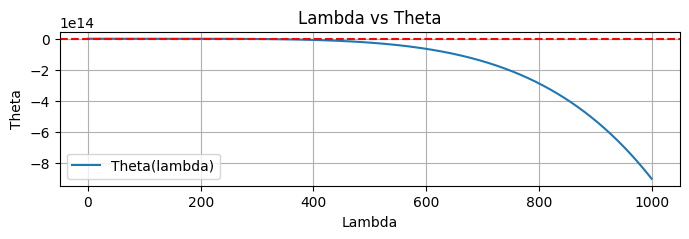

In [14]:
LAMBDA_MIN = 0
LAMBDA_MAX = 1000

# Define a range of positive real values for lambda
positive_lambdas = np.linspace(LAMBDA_MIN, LAMBDA_MAX, 10000)

# Calculate theta for each lambda
theta_values = []
for lambd in positive_lambdas:
    theta = theta_function(lambd)
    theta_values.append(theta)

plot_lambda_vs_theta(positive_lambdas, theta_values)

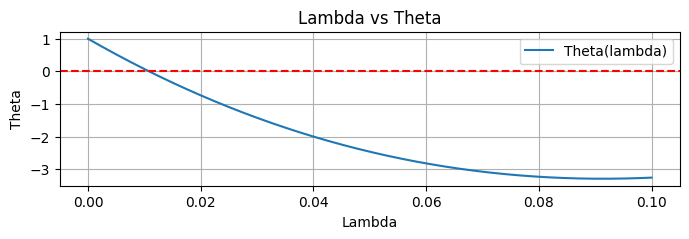

In [15]:
LAMBDA_MIN = 0
LAMBDA_MAX = 0.1

# Define a range of positive real values for lambda
positive_lambdas = np.linspace(LAMBDA_MIN, LAMBDA_MAX, 10000)

# Calculate theta for each lambda
theta_values = []
for lambd in positive_lambdas:
    theta = theta_function(lambd)
    theta_values.append(theta)

plot_lambda_vs_theta(positive_lambdas, theta_values)

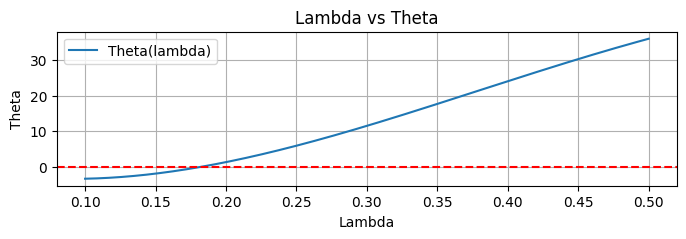

In [16]:
LAMBDA_MIN = 0.1
LAMBDA_MAX = 0.5

# Define a range of positive real values for lambda
positive_lambdas = np.linspace(LAMBDA_MIN, LAMBDA_MAX, 10000)

# Calculate theta for each lambda
theta_values = []
for lambd in positive_lambdas:
    theta = theta_function(lambd)
    theta_values.append(theta)

plot_lambda_vs_theta(positive_lambdas, theta_values)

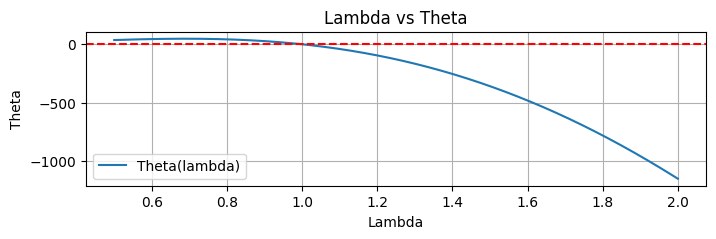

In [17]:
LAMBDA_MIN = 0.5
LAMBDA_MAX = 2

# Define a range of positive real values for lambda
positive_lambdas = np.linspace(LAMBDA_MIN, LAMBDA_MAX, 10000)

# Calculate theta for each lambda
theta_values = []
for lambd in positive_lambdas:
    theta = theta_function(lambd)
    theta_values.append(theta)

plot_lambda_vs_theta(positive_lambdas, theta_values)

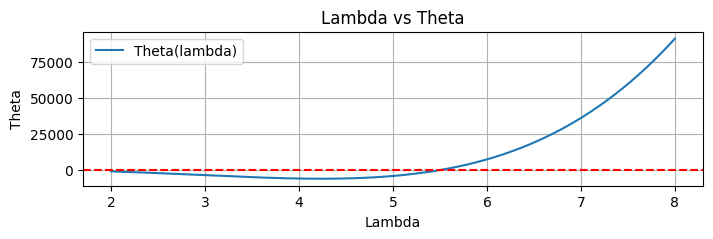

In [18]:
LAMBDA_MIN = 2
LAMBDA_MAX = 8

# Define a range of positive real values for lambda
positive_lambdas = np.linspace(LAMBDA_MIN, LAMBDA_MAX, 10000)

# Calculate theta for each lambda
theta_values = []
for lambd in positive_lambdas:
    theta = theta_function(lambd)
    theta_values.append(theta)

plot_lambda_vs_theta(positive_lambdas, theta_values)

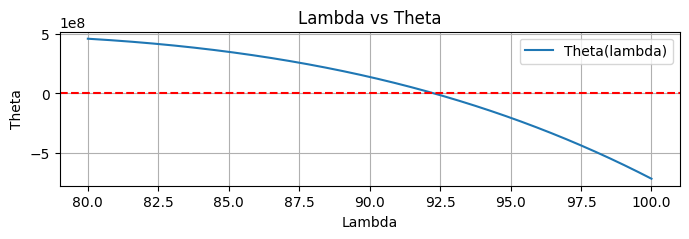

In [19]:
LAMBDA_MIN = 80
LAMBDA_MAX = 100

# Define a range of positive real values for lambda
positive_lambdas = np.linspace(LAMBDA_MIN, LAMBDA_MAX, 10000)

# Calculate theta for each lambda
theta_values = []
for lambd in positive_lambdas:
    theta = theta_function(lambd)
    theta_values.append(theta)

plot_lambda_vs_theta(positive_lambdas, theta_values)

Foi desenvolvida uma função para achar uma raiz e outra função para usar essa primeira função e continuar a busca para achar outras raízes

In [20]:
def find_root_newton_raphson(x0, func, d_func, tol=1e-6, max_iter=1000):
    """
    Apply the Newton-Raphson method to find a root of a function.

    Parameters:
    - x0 (float): Initial guess for the root.
    - func (callable): Function whose root is to be found. It must take a single argument.
    - d_func (callable): Derivative of the function. It must take a single argument.
    - tol (float): Tolerance for the convergence of the method. The method stops when the 
      absolute difference between successive iterations is less than tol.
    - max_iter (int): Maximum number of iterations to perform.

    Returns:
    - float: Approximation to the root rounded to 10 decimal places.

    Raises:
    - ValueError: If the derivative at any point is zero, as the Newton-Raphson method cannot proceed.
    """
    x = x0
    for i in range(max_iter):
        f_val = func(x)
        df_val = d_func(x)
        if df_val == 0:
            raise ValueError(
                "Derivative is zero. Newton-Raphson method fails.")
        x_new = x - f_val / df_val
        if abs(x_new - x) < tol:
            return round(x_new, 10)
        x = x_new
    return round(x, 10)

def find_all_roots_newton(func,
                          d_func,
                          start,
                          end,
                          num_initial_guesses,
                          tol=1e-6):
    """
    Find all roots of a given function within a specified interval using the Newton-Raphson method.

    Parameters:
    - func (callable): Function for which the roots are to be found.
    - d_func (callable): Derivative of the function.
    - start (float): Starting point of the interval.
    - end (float): Ending point of the interval.
    - num_initial_guesses (int): Number of initial guesses, which are spaced evenly across the interval.
    - tol (float): Tolerance for the convergence of the Newton-Raphson method.

    Returns:
    - list: A list of unique roots found within the interval, each rounded to 10 decimal places.

    Notes:
    - The function uses a simple method to avoid duplicates in the list of roots.
    - If the derivative of the function is zero at any guess, that guess is skipped.
    """
    guesses = np.linspace(start, end, num_initial_guesses)
    roots = []
    for guess in guesses:
        try:
            root = find_root_newton_raphson(guess, func, d_func, tol)
            if root not in roots:  # Simple check to avoid duplicates
                roots.append(root)
        except ValueError:
            continue
    return roots


Com base nas observações nos gráficos, foi possível definir um intervalor menor de 0 a 100 para uso do método numérico

In [21]:
# Theta function as described
def theta_function(lambd, S, I):
    num = np.linalg.det(S - lambd * I)
    den = np.linalg.det(S)
    return num / den

# Numerical derivative of theta function
def theta_derivative(lambd, h=1e-5):
    return (theta_function(lambd + h, S, I) - theta_function(lambd - h, S, I)) / (2 * h)

# Search interval
INF = 0
SUP = 100

roots = find_all_roots_newton(lambda x: theta_function(x, S, I), lambda x: theta_derivative(x), INF, SUP, 2000)
print("Roots found in ascending order:", sorted(roots, key=float))

Roots found in ascending order: [0.0108353591, 0.1812419015, 1.0, 5.5174879093, 92.2904348302]


Encontrando os autovalores com a biblioteca numpy:

In [22]:
# Find eigenvalues
eigenvalues = np.linalg.eigvals(S)

# Format eigenvalues as decimals
formatted_eigenvalues = ["{:.10f}".format(e) for e in eigenvalues]

# Sort eigenvalues in ascending order
sorted_eigenvalues = sorted(formatted_eigenvalues, key=float)

print("Eigenvalues in ascending order:", sorted_eigenvalues)

Eigenvalues in ascending order: ['0.0108353591', '0.1812419015', '1.0000000000', '5.5174879093', '92.2904348302']


**Relação do Autovetor com o Sistema Homogêneo**

O autovetor $v$ é uma solução para o sistema homogêneo quando a matriz $S - \lambda I$ é singular, o que é indicado pela condição:

$$
\det(S - \lambda I) = 0
$$

Isso implica que:

$$
(S - \lambda I) \cdot v = 0
$$

Onde:
- $S$ é a matriz do sistema.
- $\lambda$ é o autovalor correspondente.
- $I$ é a matriz identidade.
- $v$ é o autovetor.

A equação $(S - \lambda I) \cdot v = 0$ mostra que $v$ é um autovetor de $S$ associado ao autovalor $\lambda$. Esta é a condição fundamental para que um vetor seja considerado autovetor de uma matriz.






In [23]:
print('S = ')
print(S)

S = 
[[ 1  1  1  1  1]
 [ 1  2  3  4  5]
 [ 1  3  6 10 15]
 [ 1  4 10 20 35]
 [ 1  5 15 35 70]]


In [24]:
lambd = float(sorted_eigenvalues[2])
print('lambda: ', lambd)

I = np.eye(S.shape[0])
S_minus_lambdaI = S - lambd * I

print('S - lambda * I = ')
print(S_minus_lambdaI)

lambda:  1.0
S - lambda * I = 
[[ 0.  1.  1.  1.  1.]
 [ 1.  1.  3.  4.  5.]
 [ 1.  3.  5. 10. 15.]
 [ 1.  4. 10. 19. 35.]
 [ 1.  5. 15. 35. 69.]]


Ajustando a método de pivotamento para resultar numa matriz triangular superior com pivôs = 1

In [25]:
@execution_time_decorator
def row_reduced_echelon_form(matrix, tolerance=1E-6):
    """
    Calculate the reduced matrix using the pivoting method, normalizing pivots to 1 when possible,
    considering a tolerance for treating small numbers as zero.

    Parameters:
    matrix (numpy.ndarray): A matrix.
    tolerance (float): The tolerance level for treating numbers as zero.

    Returns:
    2D numpy array: The matrix in row-reduced echelon form.

    Raises:
    ValueError: If the input matrix is not a 2D numpy array.
    """

    # Check if the input is a 2D numpy array
    if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
        raise ValueError("Input must be a 2D numpy array.")

    # Grant elements as float
    matrix = matrix.astype(float)

    # Iterating over each column
    rows, cols = matrix.shape
    for j in range(min(rows, cols)):
        # Select the pivot as the largest absolute value for numerical stability
        pivot_index = np.argmax(abs(matrix[j:, j])) + j
        pivot = matrix[pivot_index, j]

        # Swap the row with the highest pivot to the current row
        if pivot_index != j:
            matrix[[j, pivot_index]] = matrix[[pivot_index, j]]

        # Consider pivot as zero if below the tolerance
        if abs(pivot) < tolerance:
            continue  # Skip this column if the pivot is too small

        # Normalize the pivot row (divide the row by the pivot element)
        matrix[j] = matrix[j] / pivot

        # Make elements below the pivot zero
        for i in range(j + 1, rows):
            factor = matrix[i, j]
            matrix[i] -= factor * matrix[j]

            # Set small values to zero based on tolerance
            matrix[i][abs(matrix[i]) < tolerance] = 0

    return matrix

In [26]:
red_matrix = row_reduced_echelon_form(S_minus_lambdaI)
print('reduced S-lambdaI: ')
print(red_matrix)

Execution Time for row_reduced_echelon_form: 250.7 microseconds
reduced S-lambdaI: 
[[ 1.     1.     3.     4.     5.   ]
 [ 0.     1.     3.     7.75  16.   ]
 [-0.    -0.     1.     2.375  5.5  ]
 [-0.    -0.    -0.     1.     2.   ]
 [ 0.     0.     0.     0.     0.   ]]


**Determinação do autovetor e do espaço das soluções**

O posto da matriz $(S-\lambda I) = 4$, portanto o sistema possui um grau de liberdade ($\alpha$).

Sendo o autovetor $v = [x_1, x_2, x_3, x_4, x_5]$:

A solução do sistema é dada por:
- $x_5 = \alpha$
- $x_4 = -2\alpha$
- $x_3 = -5.5\alpha - 2.375x_4$
- $x_2 = -16\alpha - 7.75x_4 - 3x_3$
- $x_1 = -5\alpha - 4x_4 - 3x_3 - x_2$

Resolvendo em função de $\alpha$:
- $x_5 = 1\alpha$
- $x_4 = -2\alpha$
- $x_3 = -5.5\alpha - 2.375(-2\alpha) = -0.75\alpha$
- $x_2 = -16\alpha - 7.75(-2\alpha) - 3(-0.75\alpha) = 1.75\alpha$
- $x_1 = -5\alpha - 4(-2\alpha) - 3(-0.75\alpha) - 1.75\alpha = 3.5\alpha$

Assim, o autovetor resultante é:

$v^T = [3.5\alpha, 1.75\alpha, -0.75\alpha, -2\alpha, \alpha]$

O espaço das soluções é dado por:

$v = \alpha \times [3.5, 1.75, -0.75, -2, 1]$

In [27]:
# Assuming non trivival solution: alfa is different than zero
alfa = -1

# Forming the vector
v = alfa * np.array([3.5, 1.75, -0.75, -2, 1])
print('v: ', v)

# Normalize the vector
v_unit = v / np.linalg.norm(v)

print('v_unit: ', v_unit)

v:  [-3.5  -1.75  0.75  2.   -1.  ]
v_unit:  [-0.76604592 -0.38302296  0.1641527   0.43774052 -0.21887026]


**Verificação da relação entre Autovetor e Autovalor**

Dada a relação de autovetor $v$ e autovalor $\lambda$, a seguinte equação deve ser satisfeita:

$ S \cdot v = \lambda \cdot v $

onde $S$ é a matriz associada ao sistema e $\lambda$ é o autovalor correspondente ao autovetor $v$.

Testando para o par encontrado:


In [28]:
# Calculate S*v
Sv = S @ v_unit
print('S*v:        ', S @ v_unit)

# Calculate lambda*v
lambda_v = lambd * v_unit
print('lambda * v: ', lambda_v)

S*v:         [-0.76604592 -0.38302296  0.1641527   0.43774052 -0.21887026]
lambda * v:  [-0.76604592 -0.38302296  0.1641527   0.43774052 -0.21887026]


Encontrando o autovetor através de método da biblioteca scipy

In [29]:
# Calculating null space
null_space_vectors = scipy.linalg.null_space(S_minus_lambdaI).flatten()

# Normalizing eigen vector
unit_vector_scipy = null_space_vectors / np.linalg.norm(null_space_vectors)

print(unit_vector_scipy.T)

[-0.76604592 -0.38302296  0.1641527   0.43774052 -0.21887026]


Testando o par encontrado com o método da biblioteca scipy

In [30]:
# Calculate S*v
Sv = S @ unit_vector_scipy
print('S*v:        ', Sv)

# Calculate lambda*v
lambda_v = lambd * unit_vector_scipy
print('lambda * v: ', lambda_v)

S*v:         [-0.76604592 -0.38302296  0.1641527   0.43774052 -0.21887026]
lambda * v:  [-0.76604592 -0.38302296  0.1641527   0.43774052 -0.21887026]


(vi) Escrever a expressão da solução geral do sistema $EX = 0$ sob a forma $X = KZ$ onde $K$ é uma matriz constante a ser obtida e $Z$ é um vetor de coordenadas independentes no espaço de soluções deste sistema;

Resposta:

In [31]:
red_E = row_reduced_echelon_form(E)
display_as_dataframe(red_E)
#print(red_E)

Execution Time for row_reduced_echelon_form: 462.7 microseconds


,0,1,2,3,4,5,6,7
0,1.0,0.0,1.0,0.000,-0.7500,-1.000000,0.750000,0.250000
1,-0.0,1.0,-1.0,-0.750,0.8750,-0.000000,-0.375000,0.125000
2,0.0,0.0,1.0,-0.625,-0.8125,0.500000,-1.187500,-0.187500
3,0.0,0.0,0.0,1.000,0.2000,0.400000,0.700000,0.300000
4,-0.0,-0.0,-0.0,-0.000,1.0000,-0.470024,0.220624,-0.556355
5,0.0,0.0,0.0,0.000,0.0000,1.000000,0.289130,0.194928


Chamando as variáveis livres de $\alpha$ e $\beta$

As equações do sistema ficam:

1. $x_1 + x_3 - 0.75x_5 - x_6 + 0.75\alpha + 0.25\beta = 0$
2. $x_2 - x_3 - 0.75x_4 + 0.875x_5 - 0.375\alpha + 0.125\beta = 0$
3. $x_3 - 0.625x_4 - 0.8125x_5 + 0.5x_6 - 1.1875\alpha - 0.1875\beta = 0$
4. $x_4 + 0.2x_5 + 0.4x_6 + 0.7\alpha + 0.3\beta = 0$
5. $x_5 - 0.47002398\alpha + 0.2206235\beta = 0$
6. $x_6 + 0.28913043\alpha + 0.19492754\beta = 0$

Resolvendo as equações em função de alpha e beta com a biblioteca simpy:

In [32]:
# Define the variables
x1, x2, x3, x4, x5, x6, alpha, beta = sp.symbols('x1 x2 x3 x4 x5 x6 alpha beta')

# Define the equations
equation1 = sp.Eq(x1 + x3 - 0.75*x5 - x6 + 0.75*alpha, 0.25*beta)
equation2 = sp.Eq(x2 - x3 - 0.75*x4 + 0.875*x5 - 0.375*alpha, 0.125*beta)
equation3 = sp.Eq(x3 - 0.625*x4 - 0.8125*x5 + 0.5*x6 - 1.1875*alpha, -0.1875*beta)
equation4 = sp.Eq(x4 + 0.2*x5 + 0.4*x6 + 0.7*alpha, 0.3*beta)
equation5 = sp.Eq(x5 - 0.47002398*x6 + 0.2206235*alpha, -0.55635492*beta)
equation6 = sp.Eq(x6 + 0.28913043*alpha, 0.19492754*beta)

# List of equations
equations = [equation1, equation2, equation3, equation4, equation5, equation6]

# Solve the system of equations
result_system = sp.solve(equations, (x1, x2, x3, x4, x5, x6))

# Display the solutions
result_system

{x1: -2.02826086096548*alpha + 0.562077301135151*beta,
 x2: 1.0239130372136*alpha + 0.302173909870187*beta,
 x3: 0.721739129379698*alpha - 0.465700487513344*beta,
 x4: -0.513043480910458*alpha + 0.314975844367518*beta,
 x5: -0.356521735447711*alpha - 0.464734301837591*beta,
 x6: -0.28913043*alpha + 0.19492754*beta}

In [33]:
# Extracting the coefficients and constructing the matrix K
K = sp.Matrix([[equation.coeff(alpha), equation.coeff(beta)] for equation in result_system.values()])

# Converting K to numpy array
K = np.array(K.evalf(), dtype=np.float64)

# Displaying the matrix K
print('K = ')
display_as_dataframe(K)

K = 


,0,1
0,-2.028261,0.562077
1,1.023913,0.302174
2,0.721739,-0.465700
3,-0.513043,0.314976
4,-0.356522,-0.464734
5,-0.289130,0.194928


Outra forma de calcular a matriz reduzida e K usando a biblioteca simpy. <br>
Essa biblioteca consegue reduzir a matriz original para uma diagonal com pivôs = 1 da parte dependente, restando diretamente a matriz K de vetores independentes.

In [34]:
# Convert the NumPy array to a SymPy matrix
E_sp = sp.Matrix(E)

# Calculate the reduced row echelon form (RREF)
E_rref_sp, pivot_columns = E_sp.rref()

# Convert the SymPy matrix back to a NumPy array
E_rref_np = np.array(E_rref_sp).astype(np.float64)

# Display the RREF in NumPy array format and pivot columns
print("E in Reduced Row Echelon Form:")
display_as_dataframe(E_rref_np)
print("Pivot Columns:")
print(pivot_columns)
print("\n")

# Identify non-pivot columns
non_pivot_columns = [i for i in range(E_rref_sp.shape[1]) if i not in pivot_columns]

# Extract non-pivot columns to form the matrix K
K_sp = - E_rref_sp[:, non_pivot_columns]

# Convert the SymPy matrix K to a NumPy array
K_np = np.array(K_sp).astype(np.float64)

# Display the matrix K
print("K = ")
display_as_dataframe(K_np)

E in Reduced Row Echelon Form:


,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,2.028261,0.562077
1,0.0,1.0,0.0,0.0,0.0,0.0,-1.023913,0.302174
2,0.0,0.0,1.0,0.0,0.0,0.0,-0.721739,-0.465700
3,0.0,0.0,0.0,1.0,0.0,0.0,0.513043,0.314976
4,0.0,0.0,0.0,0.0,1.0,0.0,0.356522,-0.464734
5,0.0,0.0,0.0,0.0,0.0,1.0,0.289130,0.194928


Pivot Columns:
(0, 1, 2, 3, 4, 5)


K = 


,0,1
0,-2.028261,-0.562077
1,1.023913,-0.302174
2,0.721739,0.465700
3,-0.513043,-0.314976
4,-0.356522,0.464734
5,-0.289130,-0.194928


Expressando $X = K*Z$ em forma matricial:

$$
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
x_5 \\
x_6
\end{pmatrix}
=
\begin{pmatrix}
-2.02826086096548 & 0.562077301135151 \\
1.0239130372136 & 0.302173909870187 \\
0.721739129379698 & -0.465700487513344 \\
-0.513043480910458 & 0.314975844367518 \\
-0.356521735447711 & -0.464734301837591 \\
-0.28913043 & 0.19492754
\end{pmatrix}
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
$$

(vii) Plotar (via SURF) a projeção de $F(X)$ sobre o espaço das soluções do sistema $EX = 0$, isto é, $F(X(Z))$

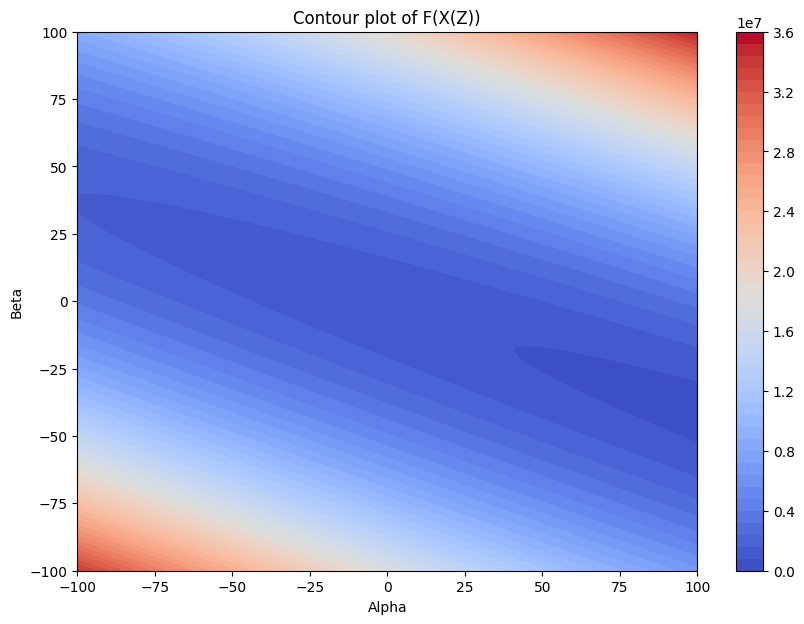

In [35]:
# Define the objective function F_Z
def F_Z(alpha, beta):
    Z = np.array([alpha, beta])
    X_red = np.dot(K, Z) # finding x1 to x6 with alpha, beta values
    X = np.append(X_red, [alpha, beta]) # appending alpha, beta on X_red
    return 0.5 * X.T @ A @ X + B.T @ X + C

# Create a meshgrid for alpha and beta
alpha_vals = np.linspace(-1e2, 1e2, 100)
beta_vals = np.linspace(-1e2, 1e2, 100)
Alpha, Beta = np.meshgrid(alpha_vals, beta_vals)

# Compute F(X) for each pair (alpha, beta)
F_vals = np.vectorize(F_Z)(Alpha, Beta)

# Plotting
plt.figure(figsize=(10, 7))
contour = plt.contourf(Alpha, Beta, F_vals, levels=50, cmap='coolwarm')
plt.colorbar(contour)
plt.title('Contour plot of F(X(Z))')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.show()

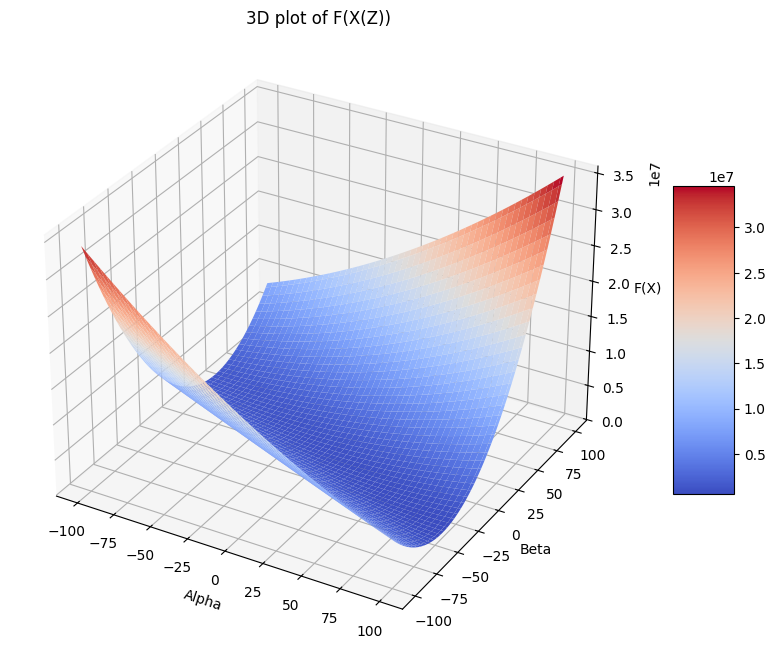

In [36]:

# Plotting the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Alpha, Beta, F_vals, cmap='coolwarm', edgecolor='none')
ax.set_title('3D plot of F(X(Z))')
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('F(X)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

(viii) Com base no item (iii), obter o ponto $x^O$ que minimiza a Função Objetivo acima resolvendo sua relação de Ponto Estacionário $\nabla_x F = 0$. Obter também o valor da Função Objetivo ($F^O = F(x^O)$) sobre este ponto.

(Note que $\nabla_x (X^T A X) = 2AX$, para $A$ simétrica)

Resposta: 

In [37]:
def is_symmetric(matrix):
    return np.array_equal(matrix, matrix.T)

is_symmetric(A)

True

Função Objetivo:
$$ F(X) = \frac{1}{2} X^T A X + B^T X + C $$

Para encontrar o mínimo, estabelecemos que o gradiente $ \nabla_X F = 0 $.

Primeiramente, sabemos que $\nabla_x (X^T A X) = 2AX$ quando $A$ é uma matriz simétrica. Portanto:

$$
\nabla_x \left( \frac{1}{2} X^T A X \right) = \frac{1}{2} \cdot 2AX = AX
$$

Continuando:

$$ \nabla_X F(X) = \nabla_X \left( \frac{1}{2} X^T A X + B^T X + C \right) $$

Dado que $ \nabla_X \left( \frac{1}{2} X^T A X \right) = AX $ para $ A $ simétrica, e $ \nabla_X \left( B^T X \right) = B $, temos:

$$ \nabla_X F(X) = AX + B $$

Estabelecendo isto para zero para o ponto estacionário:

$$ AX^O + B = 0 $$
$$ X^O = -A^{-1} B $$

Portanto, $ X^O = -A^{-1} B $ é o ponto que minimiza a função objetivo.

O valor da função no ponto mínimo $ X^O $ é:

$$ F^O = F(X^O) = \frac{1}{2} (X^O)^T A X^O + B^T X^O + C $$

Substituindo $ X^O = -A^{-1} B $:

$$ F^O = \frac{1}{2} (-A^{-1} B)^T A (-A^{-1} B) + B^T (-A^{-1} B) + C $$


Distribuindo o transposto e simplificando os sinais do termo $(-A^{-1}B)^T$ :

$$ (-A^{-1}B)^T = (A^{-1}B)^T(-1)^T = (B^T(A^{-1})^T)(-1) = -B^T(A^{-1})^T $$

Portanto, 
$$(-A^{-1}B)^T = -B^T(A^{-1})^T $$ 

Substituindo na equação original:

$$ F^O = \frac{1}{2}(-B^T(A^{-1})^T A (-A^{-1}B)) + B^T (-A^{-1}B) + C $$

Simplificando $(A^{-1})^T A$:

Sabemos que $(A^{-1})^T$ é a inversa transposta de $A$. Quando multiplicada por $A$, temos a identidade:

$$
(A^{-1})^T A = I
$$

   Portanto:

$$
F^O = \frac{1}{2}(-B^T I (-A^{-1}B)) + B^T (-A^{-1}B) + C
$$

Como $I$ é a identidade, podemos removê-la:

$$
F^O = \frac{1}{2}(-B^T (-A^{-1}B)) + B^T (-A^{-1}B) + C
$$

Simplificando os sinais:

$$
F^O = \frac{1}{2}(B^T A^{-1}B) + B^T (-A^{-1}B) + C
$$

Podemos observar que $B^T (-A^{-1}B)$ é igual a $-B^T A^{-1}B$.

Assim, a equação fica:

$$
F^O = \frac{1}{2}(B^T A^{-1}B) - B^T A^{-1}B + C
$$

Podemos combinar os termos $\frac{1}{2}(B^T A^{-1}B)$ e $-B^T A^{-1}B$:

$$
F^O = \left( \frac{1}{2} - 1 \right) B^T A^{-1}B + C
$$

Resultando em:

$$
F^O = -\frac{1}{2} B^T A^{-1}B + C
$$


In [38]:
# Calculating X0
X0 = -(np.linalg.inv(A) @ B)
print('X0 = ')
print(X0)

X0 = 
[[ 5.55550000e+04]
 [-2.99997000e+05]
 [ 6.22216000e+05]
 [-7.11104000e+05]
 [ 4.55551000e+05]
 [-1.55554000e+05]
 [ 2.22220000e+04]
 [ 1.13155693e-07]]


In [39]:
# Calculating F0 with simplified objective function
F0 = -0.5 * B.T @ np.linalg.inv(A) @ B + C
print('F0 =', F0)

F0 = [[-6.77998765e+08]]


In [40]:
# Calculating F0 with original objective function
def F_X(X):
    return 0.5 * X.T @ A @ X + B.T @ X + C

F0 = F_X(X0)
print('F0 =', F0)

F0 = [[-6.77998766e+08]]


In [41]:
# Calculating F0 with original objective function with other symbology
F0 = 0.5 * np.dot(X0.T, np.dot(A, X0)) + np.dot(B.T, X0) + C
print('F0 =', F0)

F0 = [[-6.77998766e+08]]


(ix) Obter o ponto $x^*$ que minimiza a Função Objetivo acima sobre o espaço das soluções do sistema $EX = 0$, resolvendo a relação de Ponto Estacionário Reduzida $\nabla_z F(X(Z)) = 0$. Obter também o valor da Função Objetivo ($F^* = F(X^*)$) sobre este ponto. <br>
(Note que $\nabla_z F(X(Z)) = [ \nabla_z X^T ] \nabla_x F$, portanto: $\nabla_z F(X(Z)) = K^T \nabla_x F$)

Resposta:


Para garantir que $X$ satisfaça a restrição $EX = 0$, $K$ deve ser tal que suas colunas formem uma base para o espaço nulo de $E$.
$$
EX = E(KZ) = 0 \quad \Rightarrow \quad K \text{ está no espaço nulo de } E
$$

Usando a relação $\nabla_Z F(X(Z)) = K^T \nabla_X F$, sabendo que $\nabla_X F(X) = A X + B$:
$$
\nabla_Z F = K^T (A X + B)
$$
Substituindo $X = KZ$:
$$
\nabla_Z F = K^T (A (KZ) + B) = K^T (A KZ + B)
$$

Para encontrar $Z$ que zera o gradiente, resolvemos:
$$
K^T (A KZ + B) = 0
$$
Expandindo:
$$
K^T A KZ + K^T B = 0
$$
Isolamos $Z$:
$$
K^T A KZ = -K^T B
$$
Multiplicamos ambos os lados por $(K^T A K)^{-1}$ (assumindo que é inversível):
$$
Z = -(K^T A K)^{-1} K^T B
$$

Finalmente, substituímos $Z$ de volta em $X = KZ$:
$$
X^* = KZ = -K (K^T A K)^{-1} K^T B
$$

Portanto, a solução $X^*$ considerando as restrições $EX = 0$ é:
$$
X^* = -K (K^T A K)^{-1} K^T B
$$
onde $K$ é escolhido tal que $E(KZ) = 0$.


In [42]:
# Find K* to satisfy E(KZ) = 0
K_star = scipy.linalg.null_space(E)

# Calculate X* with the equation above
X_star1 = -K_star @ np.linalg.inv(K_star.T @ A @ K_star) @ K_star.T @ B

print('X* = ')
print(X_star1)

X* = 
[[-925.73960932]
 [ 588.18746093]
 [ 274.61516884]
 [-198.52178899]
 [-278.95851637]
 [-108.28576088]
 [ 513.5797709 ]
 [-206.2601434 ]]


In [43]:
F_star1 = 0.5 * X_star1.T @ A @ X_star1 + B.T @ X_star1 + C
print('F* = ')
display_as_dataframe(F_star1)

F* = 


,0
0,-885527.181184


(x) Obter o mesmo $x^*$ utilizando o método dos Multiplicadores de Lagrange, isto é, via solução do seguinte problema de Ponto Estacionário da Função Lagrangeana $\mathcal{A}(X, \lambda) = F(X) + \lambda^T EX$:

$$
\nabla_x \mathcal{A} = 0 \\
\nabla_\lambda \mathcal{A} = 0
$$

onde $\lambda$ é o vetor de multiplicadores de Lagrange.

Resposta:

Para isso será necessário resolver um sistema de equações para encontrar $X$ e $\lambda$.

Calculando os gradientes:

Gradiente em relação a $X$
Para a função $ F(X) $:
$$ \nabla_X F(X) = A X + B $$

Para a função $\mathcal{A}(X, \lambda)$:
$$ \nabla_X \mathcal{A}(X, \lambda) = \nabla_X \left( \frac{1}{2} X^T A X + B^T X + C + \lambda^T (E X) \right) $$
$$ \nabla_X \mathcal{A}(X, \lambda) = A X + B + E^T \lambda $$

Gradiente em relação a $\lambda$
$$ \nabla_\lambda \mathcal{A}(X, \lambda) = E X $$

Agora temos o sistema de equações:
$$ A X + B + E^T \lambda = 0 $$
$$ E X = 0 $$

Colocando na Forma Matricial:
A primeira equação pode ser reorganizada como $ AX + E^T \lambda = -B $.
A segunda equação já está na forma apropriada.

Para resolver simultaneamente as duas equações, podemos concatenar as matrizes e os vetores em um sistema expandido.

Podemos reescrever o sistema como:
$$
\begin{bmatrix}
A & E^T \\
E & 0
\end{bmatrix}
\begin{bmatrix}
X^* \\
\lambda
\end{bmatrix}
=
\begin{bmatrix}
-B \\
0
\end{bmatrix}
$$

Montagem das Matrizes e Vetores no Código:**
- $ A_{eq} $ é a matriz expandida que inclui $ A $ e $ E^T $ na primeira linha, e $ E $ e uma matriz de zeros na segunda linha.
- $ B_{eq} $ é o vetor resultado expandido que inclui $ -B $ e um vetor de zeros.

In [44]:
# System
# AX + B + E.T @ lambda = 0
# EX = 0

# System solution using scipy
A_eq = np.block([
    [A, E.T],
    [E, np.zeros((E.shape[0], E.shape[0]))]
])
B_eq = np.block([
    [-B],
    [np.zeros((E.shape[0], 1))]
])

solution = scipy.linalg.solve(A_eq, B_eq)

X_star2 = solution[:A.shape[1]]
lambda_star = solution[A.shape[1]:]

# Display the solutions
print("X* = ")
print(X_star2)
print("\nLambda* = ")
print(lambda_star)

X* = 
[[-925.73960932]
 [ 588.18746093]
 [ 274.61516884]
 [-198.52178899]
 [-278.95851637]
 [-108.28576088]
 [ 513.5797709 ]
 [-206.2601434 ]]

Lambda* = 
[[ 10882.82862807]
 [  8707.31644152]
 [ 10116.6909687 ]
 [ -3987.10941752]
 [-14539.65913727]
 [ -1692.00588393]]


Encontrando o ponto ótimo com restrição X* com a biblioteca scipy para comparar com os resultados acima:

In [45]:
# Objective function
def F_X(X):
    return 0.5 * X.T @ A @ X + B.T @ X + C

# Constraint 
def constraint_eq(X):
    return E @ X

initial_guess = np.zeros((8, 1)).flatten()

# Define constrain as required on scipy
constraints = {'type': 'eq', 'fun': constraint_eq}

# Call optimization method
result = scipy.optimize.minimize(F_X, initial_guess, method='SLSQP', constraints=constraints)

# Extract X optimal from result
opt_X1 = result.x

print(f"Optimal X: {opt_X1}")
print(f"Minimum F_X value: {F_X(opt_X1)}")

Optimal X: [-925.73963962  588.18748019  274.61517782 -198.52179548 -278.9585255
 -108.28576442  513.57978772 -206.26015016]
Minimum F_X value: [-885527.18118393]


Comparando os resultados de X* para os 3 diferentes métodos

In [46]:
# Flatten the arrays to 1-dimensional for DataFrame creation
X_star1_flat = X_star1.flatten()
X_star2_flat = X_star2.flatten()

# Creating the DataFrame
data = {
    'X*1': X_star1_flat,
    'X*2': X_star2_flat,
    'optX scipy': opt_X1,
    'X*1 - X*2': X_star1_flat - X_star2_flat
}

df1 = pd.DataFrame(data)

# Display the DataFrame
df1

,X*1,X*2,optX scipy,X*1 - X*2
0,-925.739609,-925.739609,-925.739640,3.751666e-12
1,588.187461,588.187461,588.187480,1.250555e-11
2,274.615169,274.615169,274.615178,-1.932676e-12
3,-198.521789,-198.521789,-198.521795,1.477929e-12
4,-278.958516,-278.958516,-278.958526,0.000000e+00
5,-108.285761,-108.285761,-108.285764,1.946887e-12
6,513.579771,513.579771,513.579788,-5.684342e-13
7,-206.260143,-206.260143,-206.260150,-5.400125e-13


(xi) Partindo de um ponto qualquer $X_0$ (escolha um) aplique 8 sucessivas minimizações unidimensionais (1D) sobre cada um dos vetores da base conjugada $[P_1, P_2, P_3, P_4, P_5, P_6, P_7, P_8]$ obtendo, sucessivamente, os pontos $[X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8]$. Verifique então que $X_8$ é $X^O$. Para minimização 1D sobre a reta $X(\theta) = X_{k-1} + P_k \theta$, o problema seguinte deve ser resolvido (figura ilustra a etapa $k$ deste processo):

$$
\min_{\theta} F(X(\theta)) \quad \text{onde} \quad X(\theta) = X_{k-1} + P_k \theta
$$

Mostre que a solução desta Busca 1D é $X_k = X_{k-1} + P_k \theta^*$ onde $\theta^* = - \frac{P_k^T (B + AX_{k-1})}{P_k^T AP_k}$

Resposta:

Para demonstrar que a solução da busca 1D é $X_k = X_{k-1} + P_k \theta^*$ onde $θ^*$ é dado por:

$$
\theta^* = -\frac{P_k^T (B + AX_{k-1})}{P_k^T AP_k}
$$

podemos seguir os seguintes passos:

1. Definir a função objetivo $F(X)$:

$$
F(X) = \frac{1}{2} X^T A X + B^T X + C
$$

2. Substituir $X$ pela expressão $X(\theta) = X_{k-1} + P_k \theta$ na função $F$:

$$
F(X(\theta)) = \frac{1}{2} (X_{k-1} + P_k \theta)^T A (X_{k-1} + P_k \theta) + B^T (X_{k-1} + P_k \theta) + C
$$

3. Expandir e simplificar a expressão de $F(X(\theta))$:

$$
F(X(\theta)) = \frac{1}{2} (X_{k-1}^T A X_{k-1} + 2 \theta X_{k-1}^T A P_k + \theta^2 P_k^T A P_k) + B^T X_{k-1} + \theta B^T P_k + C
$$

$$
F(X(\theta)) = \frac{1}{2} X_{k-1}^T A X_{k-1} + \theta X_{k-1}^T A P_k + \frac{1}{2} \theta^2 P_k^T A P_k + B^T X_{k-1} + \theta B^T P_k + C
$$

4. Derivar $F(X(\theta))$ em relação a $\theta$ e igualar a zero para encontrar o ponto crítico:

$$
\frac{dF}{d\theta} = X_{k-1}^T A P_k + \theta P_k^T A P_k + B^T P_k = 0
$$

$$
\theta (P_k^T A P_k) = -(X_{k-1}^T A P_k + B^T P_k)
$$

$$
\theta^* = -\frac{X_{k-1}^T A P_k + B^T P_k}{P_k^T A P_k}
$$

$$
\theta^* = -\frac{P_k^T (B + AX_{k-1})}{P_k^T AP_k}
$$

Assim, a solução da busca 1D é:

$$
X_k = X_{k-1} + P_k \theta^*
$$

onde

$$
\theta^* = -\frac{P_k^T (B + AX_{k-1})}{P_k^T AP_k}
$$


In [47]:
# Initialize X_0
X_k = np.zeros((8, 1))

# List to store the values of X_k
X_values = []

# Loop for 8 successive unidimensional minimizations using conjugate base vectors
for k in range(8):
    P_k = P[:, k].reshape(-1, 1)

    # Calculate theta*
    theta_star = - (P_k.T @ (B + A @ X_k)) / (P_k.T @ A @ P_k)

    # Update X_k
    X_k = X_k + P_k * theta_star

    # Store the value of X_k
    X_values.append(X_k.copy())

# Display the final values of X_k at each step
# for i, X in enumerate(X_values, start=1):
#     print(f"X_{i} = \n{X}\n")

# Display the final value
print("X_k:")
print(X_k)

X_k:
[[ 5.55550004e+04]
 [-2.99997000e+05]
 [ 6.22216000e+05]
 [-7.11104000e+05]
 [ 4.55551000e+05]
 [-1.55554000e+05]
 [ 2.22220001e+04]
 [ 3.48977192e-05]]


In [48]:
def F_X(X):
    return 0.5 * X.T @ A @ X + B.T @ X + C

print('F(Xk) = ' )
print(F_X(X_k))

F(Xk) = 
[[-6.77998766e+08]]


In [49]:
# Calculating the difference
difference = X0 - X_k

# Flatten the arrays to 1-dimensional for DataFrame creation
X0_flat = X0.flatten()
Xk_flat = X_k.flatten()
difference_flat = difference.flatten()

# Creating the DataFrame
data = {
    'X0': X0_flat,
    'Xk': Xk_flat,
    'X0 - Xk': difference_flat
}

df2 = pd.DataFrame(data)

# Display the DataFrame
df2

,X0,Xk,X0 - Xk
0,5.555500e+04,55555.000450,-0.000451
1,-2.999970e+05,-299996.999648,-0.000351
2,6.222160e+05,622216.000253,-0.000254
3,-7.111040e+05,-711103.999796,-0.000200
4,4.555510e+05,455551.000120,-0.000124
5,-1.555540e+05,-155553.999902,-0.000095
6,2.222200e+04,22222.000057,-0.000058
7,1.131557e-07,0.000035,-0.000035


Conferindo o valor de X ótimo e F(X) por uma otimização com a biblioteca scipy

In [53]:
def F_X(X):
    return 0.5 * X.T @ A @ X + B.T @ X + C

# Initial guess
initial_guess = np.zeros((8, 1)).flatten()

# Perform the optimization with SLSQP (Sequential Least SQuares Programming)
result = scipy.optimize.minimize(F_X, initial_guess, method='SLSQP')

# Extract the optimal alpha and beta
opt_X2 = result.x

# Print the results
print(f"Optimal X: {opt_X2}")
print(f"Minimum F_X value: {F_X(opt_X2)}")

Optimal X: [  40364.84049726 -212406.36689745  405840.71137402 -409993.36097801
  201274.98555073  -25435.27094975  -15098.67682146    4624.18159405]
Minimum F_X value: [-6.47976054e+08]


Comparando com o X ótimo (sem restrição) obtido analiticamente $X^0$ com o  método de otimização da biblioteca scipy, percebe-se um valor bastante próximo da F_X, porém o X ótimo estimado ainda está numa certa distância do X ótimo da solução analítica. <br>

In [54]:
# Calculating the difference
difference = X0_flat - opt_X2

# Creating the DataFrame
data = {
    'X0': X0_flat,
    'opt_X scipy': opt_X2,
    'X0 - opt_X scipy': difference
}

df3 = pd.DataFrame(data)

# Display the DataFrame
df3

,X0,opt_X scipy,X0 - opt_X scipy
0,5.555500e+04,40364.840497,15190.159502
1,-2.999970e+05,-212406.366897,-87590.633101
2,6.222160e+05,405840.711374,216375.288624
3,-7.111040e+05,-409993.360978,-301110.639019
4,4.555510e+05,201274.985551,254276.014445
5,-1.555540e+05,-25435.270950,-130118.729048
6,2.222200e+04,-15098.676821,37320.676821
7,1.131557e-07,4624.181594,-4624.181594
